In [3]:
# Import drive and connect
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Check GPU
!nvidia-smi

Tue Mar  9 22:55:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
# import main modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score


In [6]:
# download and import packages for reading .tif files

!pip install pyrsgis
from pyrsgis import raster
from pyrsgis.convert import changeDimension

Warning! matplotlib_scalebar library not found. You may not be able to export map directly.


In [ ]:
# define functions for use in the notebook - these should be moved to a separate file

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

# def 

In [7]:
# grab image file
file = "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif"

In [8]:
# read in band data
ds1, features_ndvi = raster.read(file, bands=9)
ds2, labels_mangroves = raster.read(file, bands=8)

# fill NaNs with 0s
features_ndvi = np.nan_to_num(features_ndvi)
labels_mangroves = np.nan_to_num(labels_mangroves)

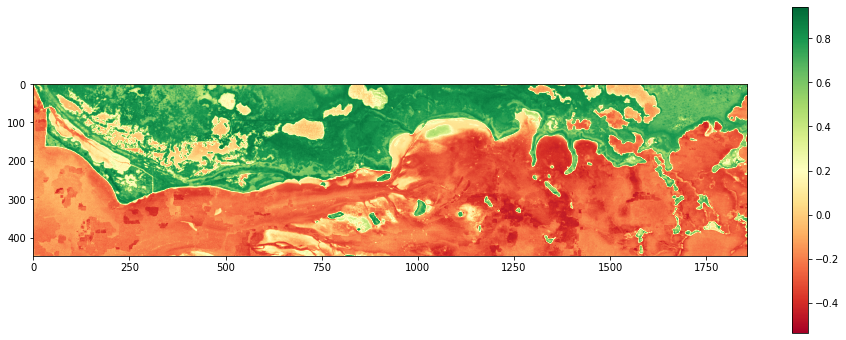

In [9]:
plt.figure(figsize=(16,6))
plt.imshow(features_ndvi, cmap='RdYlGn')
plt.colorbar()
plt.show()

In [10]:
# change dimensions for input into neural net
features_ndvi_cd = changeDimension(features_ndvi)
labels_mangroves_cd = changeDimension(labels_mangroves)

print(features_ndvi_cd.shape)
print(labels_mangroves_cd.shape)

(830079,)
(830079,)


In [11]:
nBands = 1 #features_ndvi_cd.shape[1]

In [12]:
# convert labels to int for classification
labels_mangroves_cd = (labels_mangroves_cd == 1).astype(int)
labels_mangroves_cd

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(features_ndvi_cd, labels_mangroves_cd, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

(498047,)
(498047,)
(332032,)
(332032,)


In [15]:
# normalize bands
xTrain = normalizeBand(xTrain)
xTest = normalizeBand(xTest)

In [16]:
# Define the parameters of the model
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [24]:
# fit the model
history = model.fit(xTrain, yTrain, epochs=2)


Epoch 1/2
15564/15564 [==============================] - 27s 2ms/step - loss: 0.1020 - accuracy: 0.9605
Epoch 2/2
15564/15564 [==============================] - 27s 2ms/step - loss: 0.1018 - accuracy: 0.9605


In [27]:
print(history.history)

# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [0.10201777517795563, 0.10180235654115677], 'accuracy': [0.9604635834693909, 0.9605177640914917]}


In [23]:
# Predict for test data 
yTestPredicted = model.predict(xTest)
yTestPredicted = yTestPredicted[:,1] # grab probablities for class label 1

# # Calculate and display the error metrics
yTestPredicted = (yTestPredicted>0.5).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
cMatrix = confusion_matrix(yTest, yTestPredicted)
pScore = precision_score(yTest, yTestPredicted)
rScore = recall_score(yTest, yTestPredicted)

print("Confusion matrix: for 10 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 10 nodes
 [[225080   8899]
 [  3996  94057]]

P-Score: 0.914, R-Score: 0.959


In [58]:
# load up a new image to test on
test_file = "/content/drive/MyDrive/MangroveClassification/Images/Florida_2_2000.tif"

# read in band data
ds1_2, features_ndvi_2 = raster.read(test_file, bands=9)
ds2_2, labels_mangroves_2 = raster.read(test_file, bands=8)

# fill NaNs with 0s
features_ndvi_2 = np.nan_to_num(features_ndvi_2)
labels_mangroves_2 = np.nan_to_num(labels_mangroves_2)

# change label from float to int
labels_mangroves_2 = (labels_mangroves_2 == 1).astype(int)


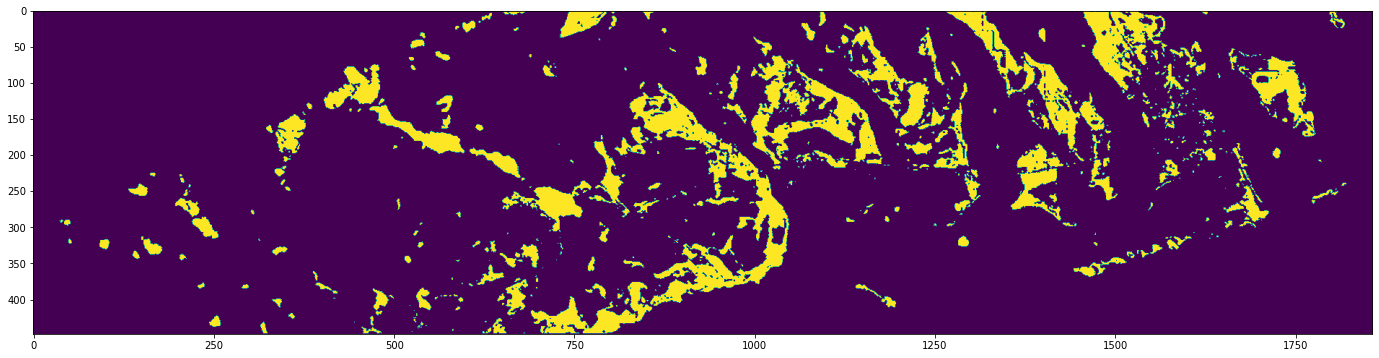

In [59]:
plt.figure(figsize=(24,6))
plt.imshow(labels_mangroves_2)
# plt.colorbar()
plt.show()

In [60]:
# change dimensions of input
features_ndvi_2_cd = changeDimension(features_ndvi_2)
labels_mangroves_2_cd = changeDimension(labels_mangroves_2)


In [61]:
print(features_ndvi_2_cd.shape)
print(labels_mangroves_2_cd.shape)

(831936,)
(831936,)


In [66]:
predicted_2nd_image = model.predict(features_ndvi_2_cd)
predicted_2nd_image = predicted_2nd_image[:,1]

In [71]:
predicted_2nd_image_at = (predicted_2nd_image>0.2).astype(int)

In [72]:
cMatrix = confusion_matrix(labels_mangroves_2_cd, predicted_2nd_image_at)
pScore = precision_score(labels_mangroves_2_cd, predicted_2nd_image_at)
rScore = recall_score(labels_mangroves_2_cd, predicted_2nd_image_at)

print("Confusion matrix: for 10 nodes\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))

Confusion matrix: for 10 nodes
 [[740336   1984]
 [ 50378  39238]]

P-Score: 0.952, R-Score: 0.438


In [73]:
prediction_2d = np.reshape(predicted_2nd_image_at, (ds2_2.RasterYSize, ds2_2.RasterXSize))


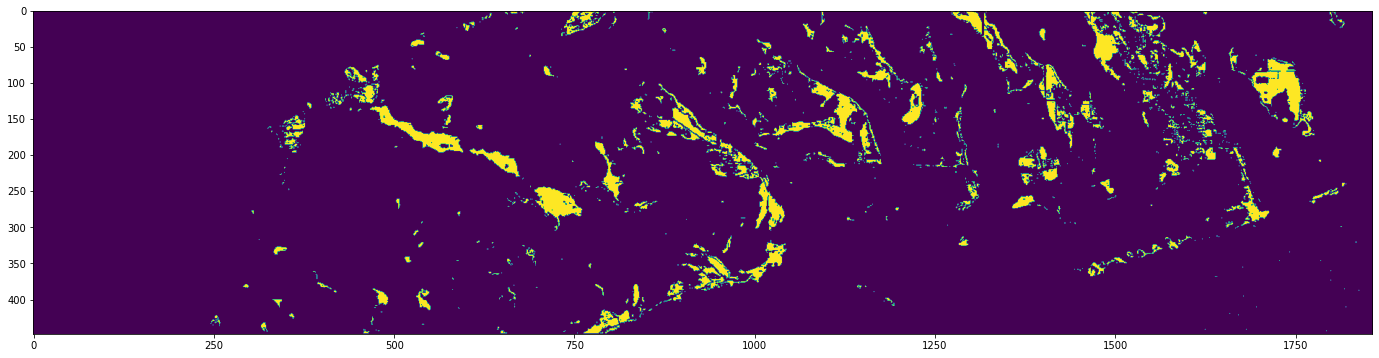

In [74]:
plt.figure(figsize=(24,6))
plt.imshow(prediction_2d)
# plt.colorbar()
plt.show()

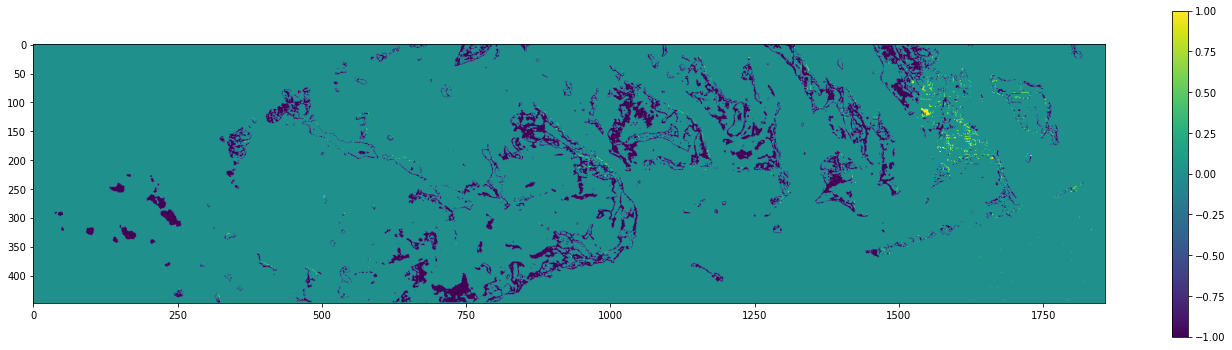

In [77]:
image_difference = prediction_2d - labels_mangroves_2
plt.figure(figsize=(24,6))
plt.imshow(image_difference)
plt.colorbar()
plt.show()